In [6]:
import numpy as np
import pandas as pd
import polars as pl
import os
import msgpack_numpy as mpn
import msgpack as mp
import matplotlib.pyplot as plt
import cv2
from cv2 import aruco
from scipy.spatial.transform import Rotation as R
from pd_support import *

In [7]:
calib_recording_folder = 'calib_yuvt3'
recording_folder = 'yuv_t3'

# Get calibration frame and transformation

In [8]:
calib_parent_dir = os.path.dirname(os.getcwd())
calib_data_dir = os.path.join(calib_parent_dir, 'MocapData', calib_recording_folder)

calib_video_file = open(os.path.join(calib_data_dir,'webcam_color.msgpack'), 'rb')
calib_timestamp_file = open(os.path.join(calib_data_dir,'webcam_timestamp.msgpack'), 'rb')

calib_video_data = mp.Unpacker(calib_video_file,object_hook=mpn.decode)
calib_timestamp_data = mp.Unpacker(calib_timestamp_file, object_hook=mpn.decode)

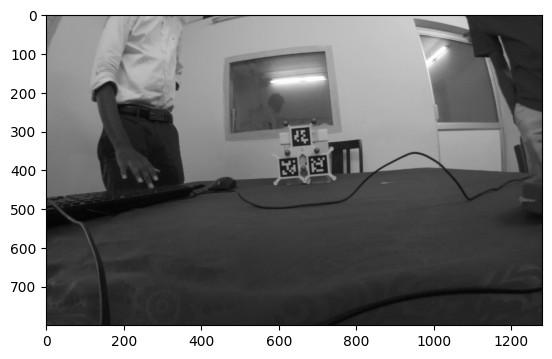

In [9]:
calib_frame = None
for _frame in calib_video_data:
    calib_frame = cv2.flip(_frame, 1)  # Flip frame horizontally
    break

if calib_frame is None:
    raise ValueError("No frames found in calib_video_data.")

dict = aruco.getPredefinedDictionary(aruco.DICT_APRILTAG_36h11)
parameters = aruco.DetectorParameters()
detector = aruco.ArucoDetector(dict, parameters)
corners, ids, rejectedImgPoints = detector.detectMarkers(calib_frame)
plt.imshow(calib_frame, cmap='gray')

### Calibration mocap path

In [10]:
mocap_file = os.path.join(calib_data_dir, calib_recording_folder+'.csv')
mocap_data, start_time = read_df_csv(mocap_file)

tr_m = get_marker_name('tr')
tl_m = get_marker_name('tl')
bl_m = get_marker_name('bl')
br_m = get_marker_name('br')

yvec = mocap_data[[tr_m['x'], tr_m['y'], tr_m['z']]].values[0] - mocap_data[[br_m['x'], br_m['y'], br_m['z']]].values[0]
xvec = mocap_data[[br_m['x'], br_m['y'], br_m['z']]].values[0] - mocap_data[[bl_m['x'], bl_m['y'], bl_m['z']]].values[0]

del mocap_data
# gram-schmidt process to make yvec orthogonal to xvec
xq = xvec / np.linalg.norm(xvec)
yvec = yvec - np.dot(yvec, xq) * xq
yq = yvec / np.linalg.norm(yvec)
zvec = np.cross(xq, yq)
zq = zvec / np.linalg.norm(zvec)

# rotation matrix from marker to world
R_m2w = np.vstack([xq, yq, zq]).T
# rotation matrix from world to marker
R_w2m = R_m2w.T

# Data path

In [11]:
parent_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(parent_dir, 'MocapData', recording_folder)

video_file = open(os.path.join(data_dir,'webcam_color.msgpack'), 'rb')
timestamp_file = open(os.path.join(data_dir,'webcam_timestamp.msgpack'), 'rb')

video_data = mp.Unpacker(video_file, object_hook=mpn.decode)
timestamp_data = mp.Unpacker(timestamp_file, object_hook=mpn.decode)

# determine start stop sync pluses
start_sync = None
stop_sync = None
for i, ts in enumerate(timestamp_data):
    _sync = ts[0]
    if _sync == 1 and start_sync is None:
        start_sync = i
    if _sync == 0 and start_sync is not None:
        stop_sync = i
print(f"Start sync: {start_sync}, Stop sync: {stop_sync}")

Start sync: 250, Stop sync: None


# MoCap data path

In [12]:
mocap_file = os.path.join(data_dir, recording_folder+'.csv')
mocap_data, start_time = read_df_csv(mocap_file)

In [13]:
mocap_data.head(3)

,frame,seconds,blv1_x,blv1_y,blv1_z,blv2_x,blv2_y,blv2_z,blv3_x,blv3_y,...,sr_z,tv1_x,tv1_y,tv1_z,tv2_x,tv2_y,tv2_z,tv3_x,tv3_y,tv3_z
0,0,0.00,0.392452,0.137486,-0.038378,0.407930,0.164520,-0.073562,0.365061,0.172392,...,-0.291452,-0.090457,0.063415,0.081144,-0.071107,0.069635,0.038620,-0.117402,0.076163,0.044197
1,1,0.01,0.392387,0.137452,-0.038425,0.407869,0.164518,-0.073560,0.364984,0.172327,...,-0.291179,-0.090455,0.063443,0.081189,-0.071143,0.069680,0.038696,-0.117437,0.076144,0.044265
2,2,0.02,0.392307,0.137446,-0.038454,0.407796,0.164543,-0.073530,0.364887,0.172272,...,-0.291115,-0.090544,0.063556,0.081278,-0.071172,0.069719,0.038749,-0.117508,0.076191,0.044381


In [14]:
mocap_data.columns

Index(['frame', 'seconds', 'blv1_x', 'blv1_y', 'blv1_z', 'blv2_x', 'blv2_y',
       'blv2_z', 'blv3_x', 'blv3_y', 'blv3_z', 'brv1_x', 'brv1_y', 'brv1_z',
       'brv2_x', 'brv2_y', 'brv2_z', 'brv3_x', 'brv3_y', 'brv3_z', 'flv1_x',
       'flv1_y', 'flv1_z', 'flv2_x', 'flv2_y', 'flv2_z', 'flv3_x', 'flv3_y',
       'flv3_z', 'frv1_x', 'frv1_y', 'frv1_z', 'frv2_x', 'frv2_y', 'frv2_z',
       'frv3_x', 'frv3_y', 'frv3_z', 'sl_x', 'sl_y', 'sl_z', 'sr_x', 'sr_y',
       'sr_z', 'tv1_x', 'tv1_y', 'tv1_z', 'tv2_x', 'tv2_y', 'tv2_z', 'tv3_x',
       'tv3_y', 'tv3_z'],
      dtype='object')

In [15]:
# marker sets
shoulder_left = ['sr']
wrist_left = ['flv1', 'flv2', 'flv3']
biceps_left = ['blv1', 'blv2', 'blv3']

shoulder_right = ['sl']
wrist_right = ['frv1', 'frv2', 'frv3']
biceps_right = ['brv1', 'brv2', 'brv3']

trunk = ['tv1', 'tv2', 'tv3']

In [16]:
def return_marker_points(mocap_data, markers):
    points = []
    _marker_name = []
    for _m in markers:
        _marker_name.append(get_marker_name(_m))
    for m in _marker_name:
        points.append(mocap_data[[m['x'], m['y'], m['z']]].values)
    return np.array(points).squeeze()

In [17]:
shoulder_left_points = return_marker_points(mocap_data, shoulder_left)
shoulder_right_points = return_marker_points(mocap_data, shoulder_right)
biceps_left_points = return_marker_points(mocap_data, biceps_left)
biceps_right_points = return_marker_points(mocap_data, biceps_right)
wrist_left_points = return_marker_points(mocap_data, wrist_left)
wrist_right_points = return_marker_points(mocap_data, wrist_right)
trunk_points = return_marker_points(mocap_data, trunk)

In [18]:
biceps_left_points[0]

array([[ 0.392452,  0.137486, -0.038378],
       [ 0.392387,  0.137452, -0.038425],
       [ 0.392307,  0.137446, -0.038454],
       ...,
       [ 0.394561,  0.143844, -0.056372],
       [ 0.394548,  0.143828, -0.056362],
       [ 0.394548,  0.143794, -0.056358]], shape=(2370, 3))

In [19]:
for _t in trunk:
    _markers = [get_marker_name(_t)]
    for _m in _markers:
        print(_m)

{'x': 'tv1_x', 'y': 'tv1_y', 'z': 'tv1_z'}
{'x': 'tv2_x', 'y': 'tv2_y', 'z': 'tv2_z'}
{'x': 'tv3_x', 'y': 'tv3_y', 'z': 'tv3_z'}


# MoCap data path

In [20]:
for _frame in video_data:
    frame = cv2.flip(_frame, 1)  # Flip frame horizontally
    
    break

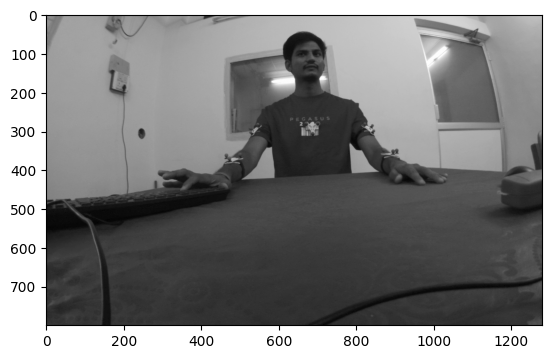

In [21]:
plt.imshow(frame, cmap='gray')